In [2]:
%load_ext autoreload
%autoreload 2

# Demonstration of image augmentation for FCU-Net
- based off of Joydeep's data augmentation, updated with s&p noise, shifting, improved elliptical transforms, and converting everything to numpy/cupy rather than tensorflow 
- there are some quirks regarding how he organized his tensors in terms of channels first/last that I have left for now, but which I can clean up once we know exactly how this will be used. 
- this notebook gives a brief demo using some data from the training set
    - augmentation could be incorporated into the dataloader (slower but requires less storage space), or it could be used to pre-augment all of the training data which are then loaded directly 

In [3]:
import numpy as np
import cupy as cp
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import os

from augment4D.augment import Image_Augmentation

ModuleNotFoundError: No module named 'augment4D'

# Helpers

In [ ]:
def change_root_path(row, rot_path, unrot_path):
    '''
    changes the root path of '/data/...' to whatever the correct file path is while keeping the nested file structure

    row: pandas series
    rot_path: Path or str to the top level dir ml-ai-4dstem-main
    unrot_path: Path or str to the top level dir ml-ai-4dstem-main-unrotated
    '''
    # get the paths for sims and training datasets

    s_training = str(row.training_name)
    s_sim = str(row.filenameOutput)
    # check if its unrotated
    # if its not unrotated we need to set the path to rot_path
    if not row.rotation_type == 'unrotated':
        s_training = Path(s_training.replace('/data', rot_path))
        s_sim = Path(s_sim.replace('/data', rot_path))
    # if its unrotated we need to set to unrotated path
    else:
        s_training = Path(s_training.replace('/data', unrot_path))
        s_sim = Path(s_sim.replace('/data', unrot_path))

    row.training_name = s_training
    row.filenameOutput =  s_sim
    return row


# load some example data 
- same template as the demo .ipynb that Alex shared

In [4]:
unrot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main-unrotated'
rot_path = '/global/cfs/cdirs/m4269/FCU-Net_Data/ml-ai-4dstem-main'
dataframe_path = "/global/cfs/cdirs/m4269/FCU-Net_Data/full_dataframe_FCU-Net_data.pkl"

df_orig = pd.read_pickle(dataframe_path)
df = df_orig.apply(change_root_path, rot_path=rot_path, unrot_path=unrot_path, axis=1)
# df = df[df.training_name.apply(os.path.exists)]
df

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/m4269/FCU-Net_Data/full_dataframe_FCU-Net_data.pkl'

In [6]:
# select just some of the data as an example
# row = df.iloc[0]
row = df[(df.mat_id == 'mp-1186898') & (df.probeSemiangle > 2) & (df.rotation_type == 'unrotated')].iloc[0]

In [7]:
# load the cbed patterns and probes
with h5py.File(row.training_name, 'r') as f:
    print(f.keys())
    cbeds = f['dataMeas'][...]
    thicknesses = f['thicknesses'][...]
    probe = f['dataProbe'][...]
    pots = f['dataPots'][...]

<KeysViewHDF5 ['dataMeas', 'dataPots', 'dataProbe', 'dataQz', 'qx', 'qy', 'qz', 'thicknesses']>


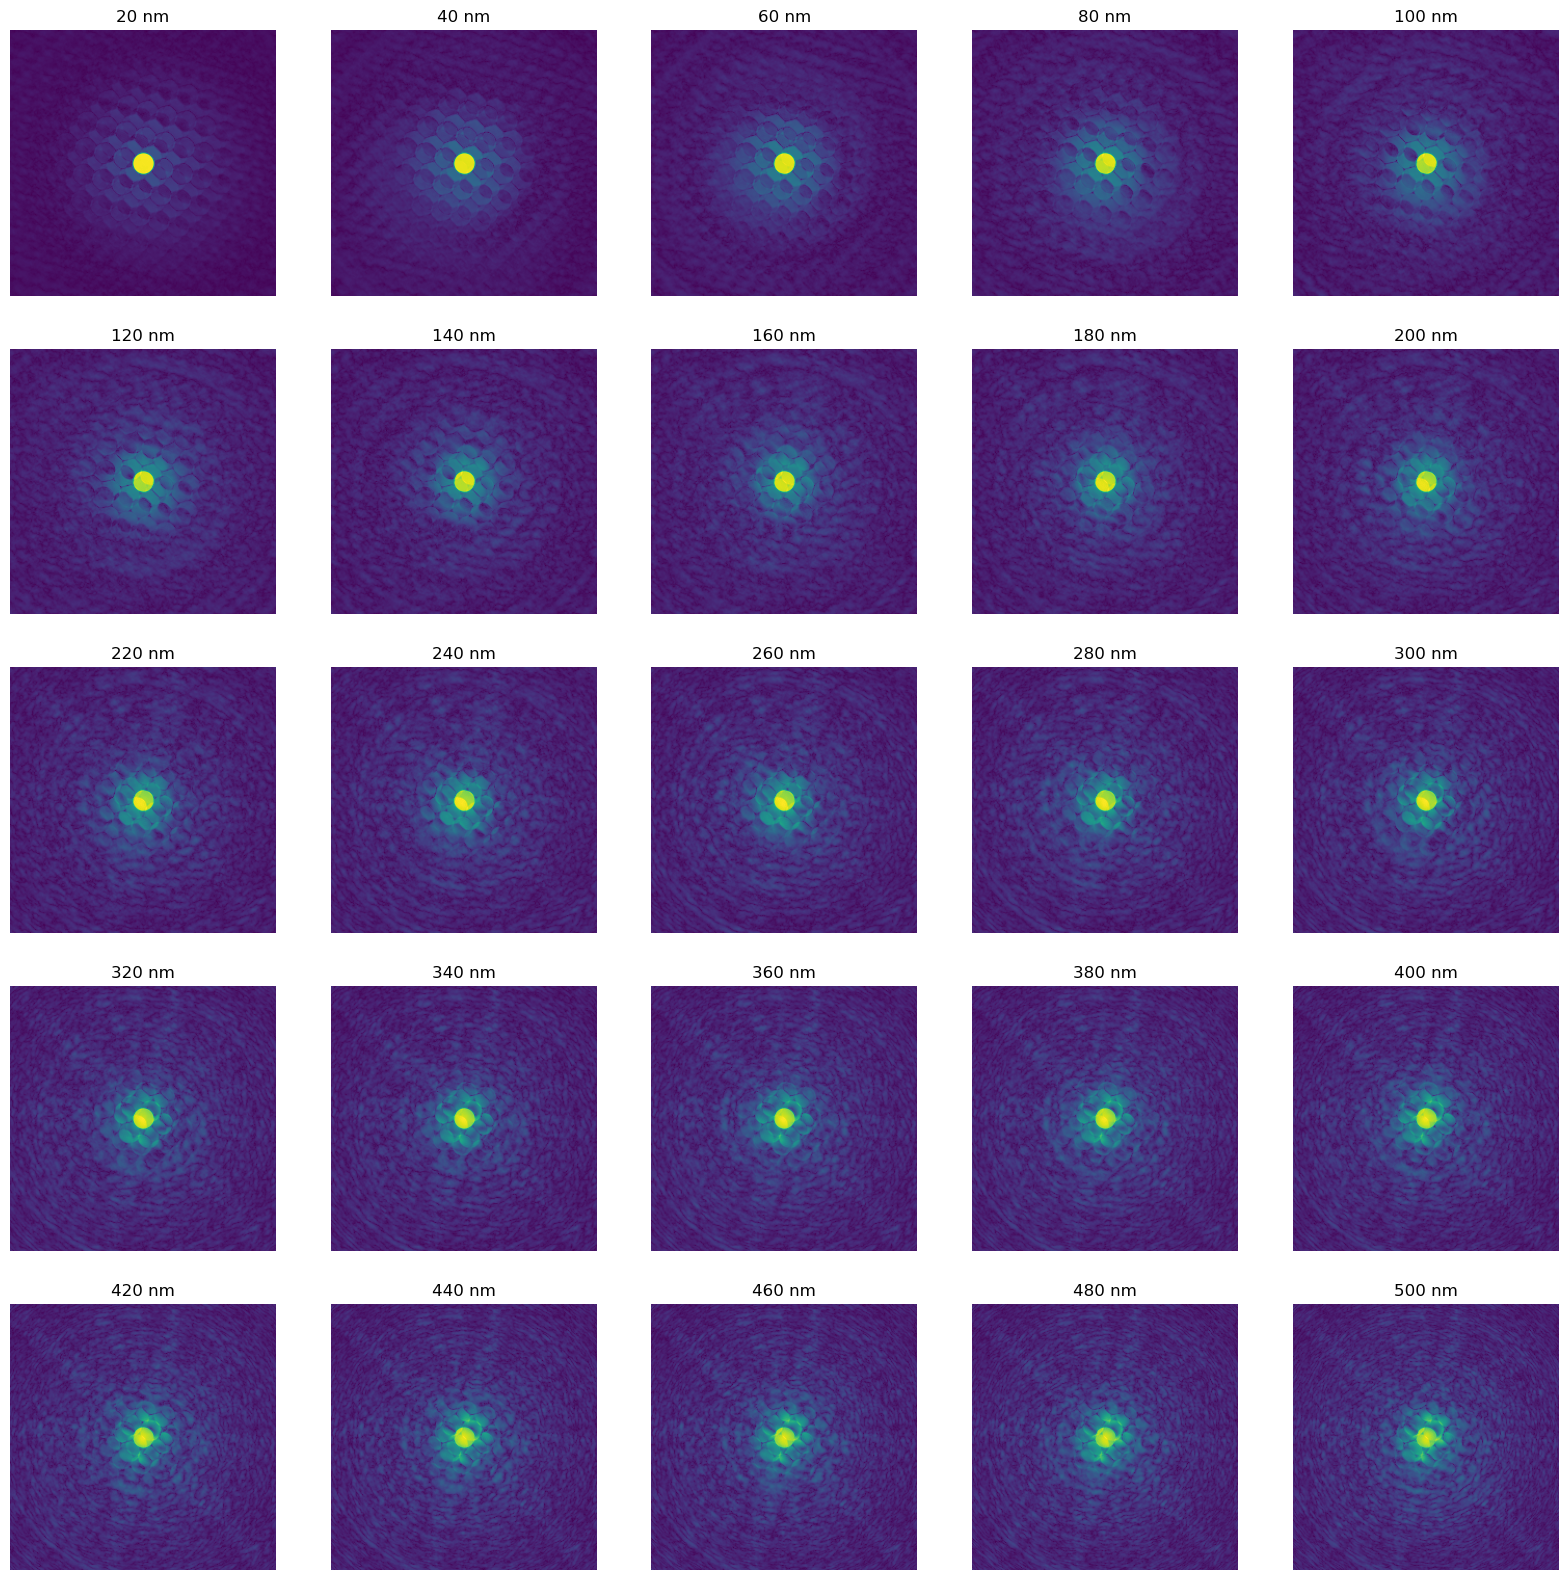

In [8]:
fig, ax = plt.subplots(5,5, figsize=(20,20))

axes = ax.ravel()

for i in range(25):
    axes[i].imshow(cbeds[...,i]**0.25)
    axes[i].set_title(f'{thicknesses[i]} nm')
    axes[i].set_axis_off()

plt.show()

# Image augmentation
- we use an Image_Augmentation object for this
    - some parameters are currently given as fixed value inputs (background, counts for poisson, s&p scaling), 
    - others are given as ranges or scale values and then chosen randomly during initialization (shift, elliptical)
    - this could probably be standardized to accept ranges for all inputs (background scale, etc.), but I guess it might depend on how it will be applied to the full training set
    
- consistent with the old implementation, this applies the same augmentations to _all images in the batch_, this means all images will have identical elliptic/shifts applied, and with the same scaling values for poisson and s&p (though the actual noise from these is not the same for each image of course)

- The original augmentation for crystal4D expected the input shape to be: (batch, height, width, channel) which is logical, but the tf tensors were kept in a different format, hence the transposing here. This can/should be adapted to whatever convention we end up using. 

- Currently there is some artifacting that occurs at the edge of the edge of the patterns when the pattern is compressed in the elliptical transform. This is minimized by only allowing magnifications of the pattern, but shearing can still lead to some artifacts especially near the corners. 

In [9]:
device = 'cpu'
augmentor = Image_Augmentation(
        add_background=True, # whether or not to apply background noise
        weightbackground=0.05, # background intensity scaling
        qBackgroundLorentz=0.05, # background cutoff offset
        add_shot=True, # whether or not to apply poisson noise
        counts_per_pixel=1e4,
        add_pattern_shift=True,
        xshift_range=(-10, 10), # float for fixed value, or range which will be picked from randomly
        yshift_range=(-10, 10), # float for fixed value, or range which will be picked from randomly
        add_ellipticity=True,
        ellipticity_scale=1e-1, # exx, eyy, and exy will be chosen from a normal distribution with this value as sigma
        add_salt_and_pepper=True,
        salt_and_pepper_scale=5e-4, # fraction of image to be (randomly) salt/peppered. currently has salt_v_pepper ratio = 1
        verbose=False,
        log_file="./logs/augment_log.csv",
        device=device, # "gpu" (cupy) or "cpu" (numpy)
        seed=42*2, # None -> random 128 bit seed, either way will be recorded in the log
        magnify_only=True, # Prevent lower magnification of patterns, which creates artifacts at the edges
)

augmentor.print_params()

Printing augmentation summary... 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
Adding background: True
	Weighted background: 0.05
	Background plasmon: 0.05
Adding shot: True
	Counts per pixel: 1.0e+04
Adding shift: True
	Pattern shift pixels (x,y): 4.64, 8.00
Adding elliptic scaling: True
	Ellipticity scaling: 0.1
	Ellipticity params (exx, eyy, exy): (0.76, 0.90, -0.12)
Adding salt & pepper: True
	Salt & pepper scaling: 5.0e-04
Random seed: 84
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 


In [10]:
cbeds_input = np.transpose(cbeds, (2,1,0))[...,None]

cbeds_aug = augmentor.augment_img(cbeds_input, probe[None,...,None])
if device == "gpu":
    cbeds_aug = cbeds_aug.get()
cbeds_aug = np.transpose(cbeds_aug.squeeze(), (2,1,0))

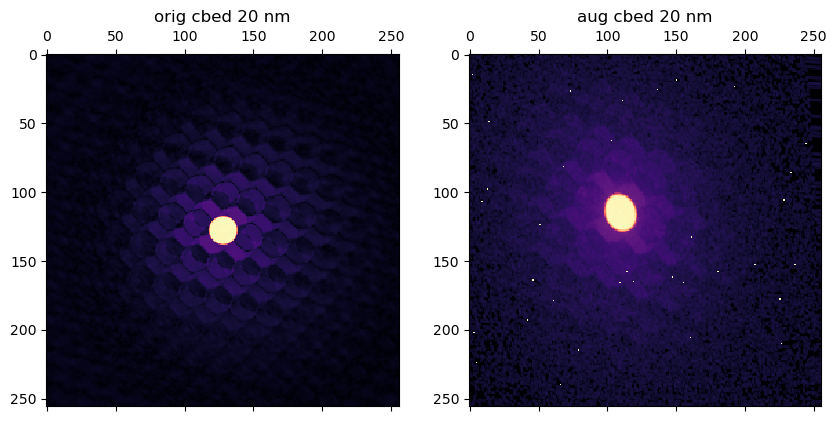

In [11]:
i = 0
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(cbeds[...,i]**0.25, cmap='magma')
axs[0].set_title(f"orig cbed {thicknesses[i]} nm")

axs[1].matshow(cbeds_aug[...,i]**0.25, cmap='magma')
axs[1].set_title(f"aug cbed {thicknesses[i]} nm")
plt.show()

we also need to apply the same augmentations to the vacuum probe measurement, though without plasmon background and shot noise.

We could also augment the potentials (ground truth labels) with ellipticity, and shifting if we so choose, but I think the current plan is to have the model try and learn the centered diffraction pattern regardless of distortions to the input data. 

In [12]:
augmentor.add_bkg = False
augmentor.add_shot = False
probe_aug = augmentor.augment_img(probe[None,...,None]).squeeze().T

# if augmenting the potential, then want to only do distortions, no S&P
augmentor.add_salt_and_pepper = False
pots_input = np.transpose(pots, (2,1,0))[...,None]
pots_aug = augmentor.augment_img(pots_input)
pots_aug = np.transpose(pots_aug.squeeze(), (2,1,0))

if device == "gpu":
    probe_aug = probe_aug.get()
    pots_aug = pots_aug.get()

augmentor.print_params()

Printing augmentation summary... 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
Adding background: False
Adding shot: False
Adding shift: True
	Pattern shift pixels (x,y): 4.64, 8.00
Adding elliptic scaling: True
	Ellipticity scaling: 0.1
	Ellipticity params (exx, eyy, exy): (0.76, 0.90, -0.12)
Adding salt & pepper: False
Random seed: 84
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 


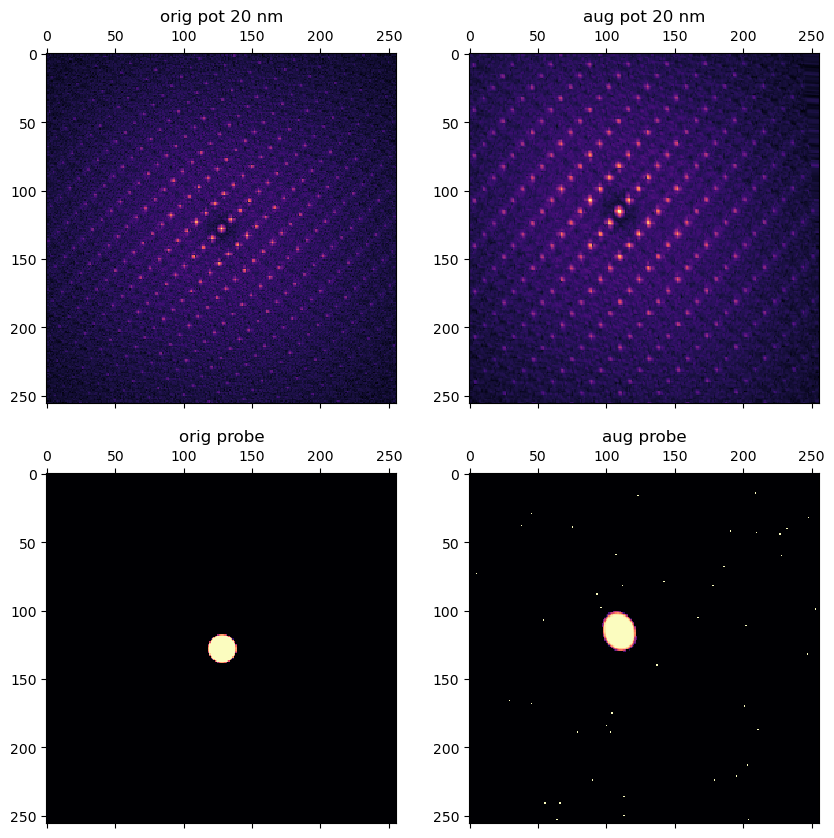

In [13]:
i = 0
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axs[0,0].matshow(pots[...,i]**0.25, cmap='magma')
axs[0,0].set_title(f"orig pot {thicknesses[i]} nm")

axs[0,1].matshow(pots_aug[...,i]**0.25, cmap='magma')
axs[0,1].set_title(f"aug pot {thicknesses[i]} nm")

axs[1,0].matshow(probe**0.25, cmap='magma')
axs[1,0].set_title(f"orig probe")

axs[1,1].matshow(probe_aug**0.25, cmap='magma')
axs[1,1].set_title(f"aug probe")

plt.show()

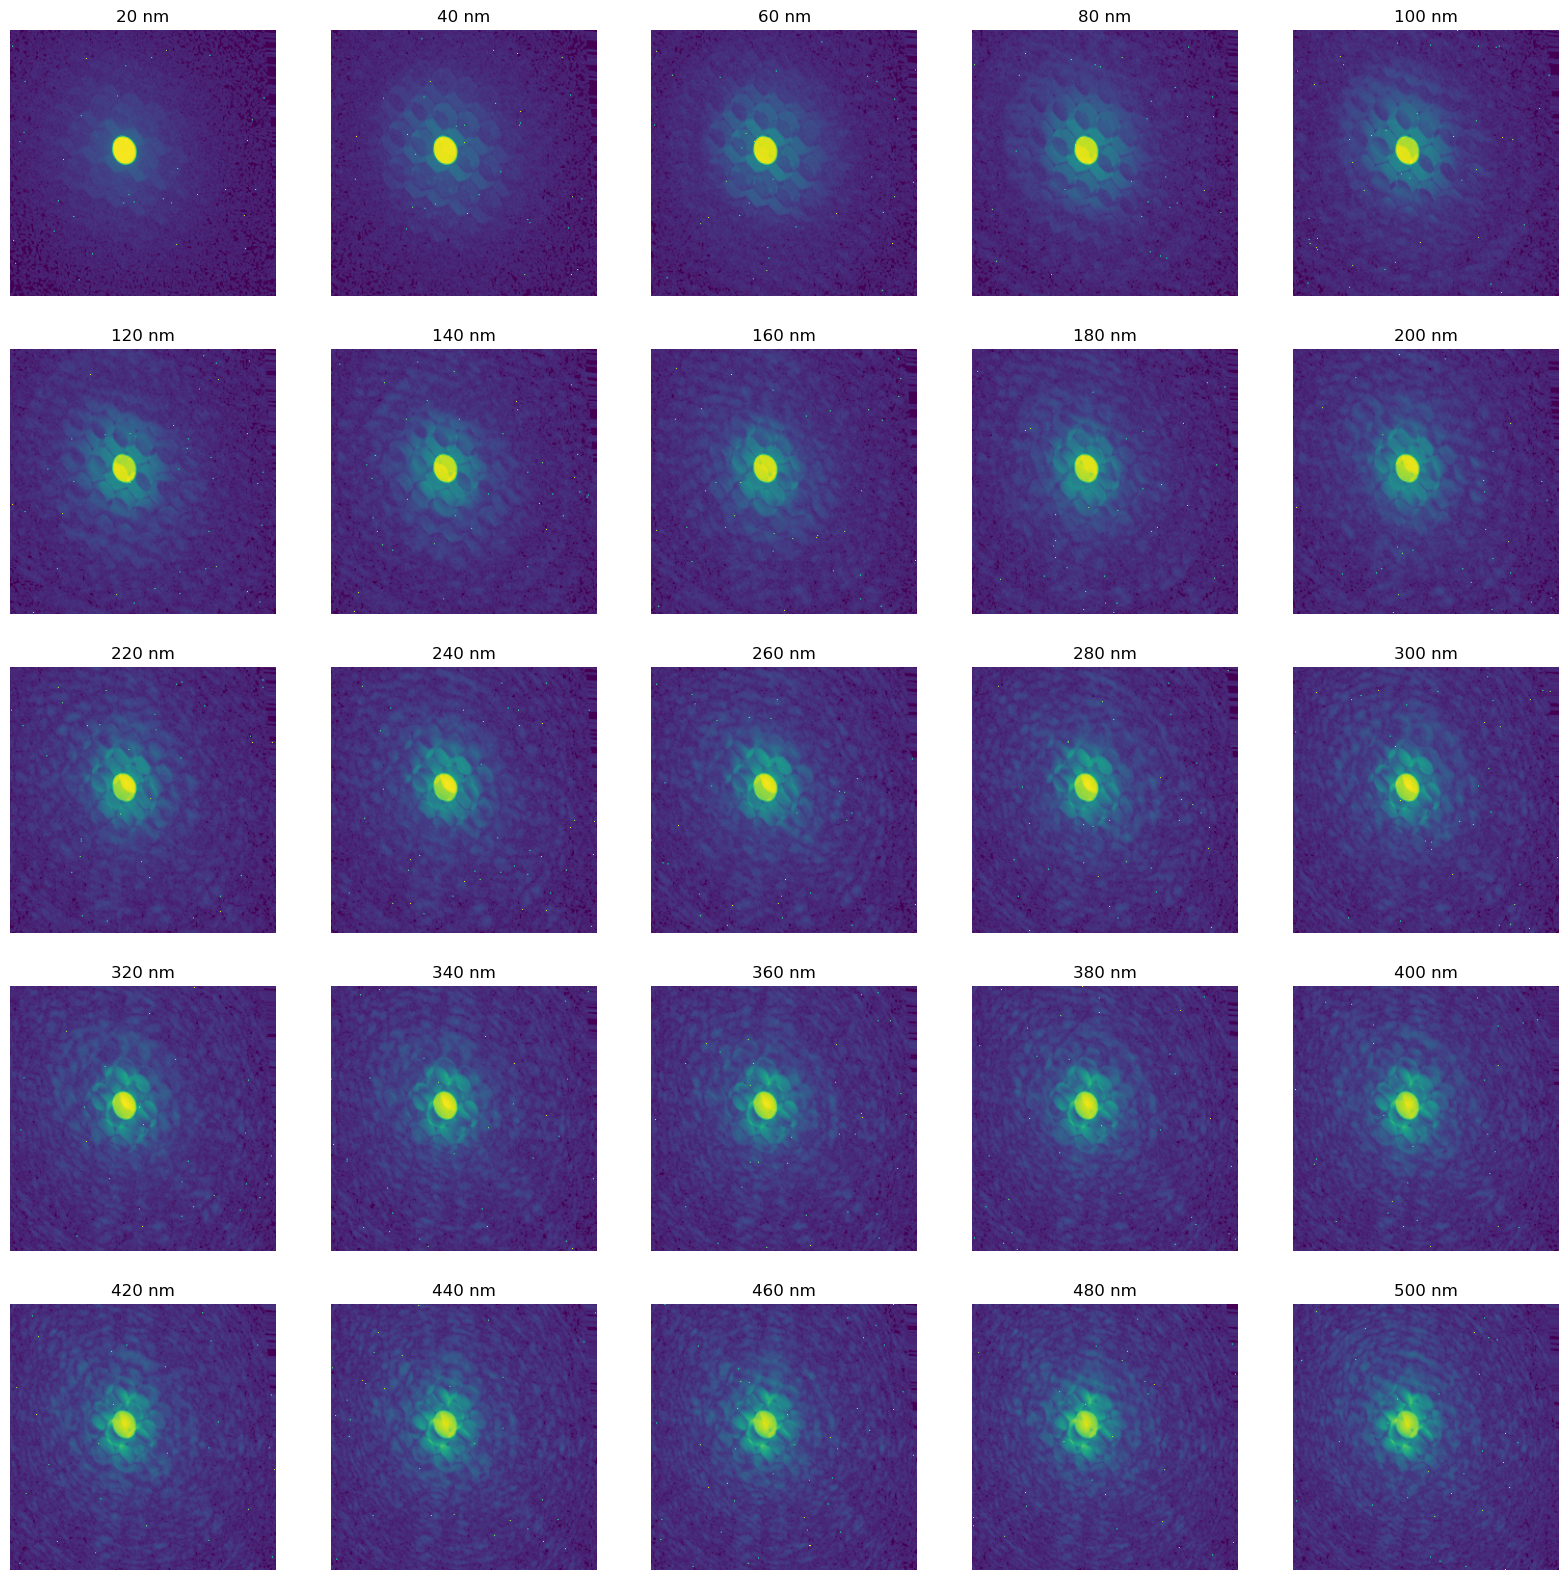

In [14]:
fig, ax = plt.subplots(5,5, figsize=(20,20))

axes = ax.ravel()

for i in range(25):
    axes[i].imshow(cbeds_aug[...,i]**0.25)
    axes[i].set_title(f'{thicknesses[i]} nm')
    axes[i].set_axis_off()

plt.show()